# Vehicle Fuel Consumption Prediction

## Import libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import xgboost as xgb
import warnings

# filter warnings
warnings.filterwarnings("ignore")

## Import dataset

In [4]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
df = pd.read_csv("auto-mpg.data", names = column_names, na_values = "?", comment = "\t", sep= " ", skipinitialspace = True)
df["Km/lt"] = df["MPG"]*0.425144
df = df.drop(columns="MPG")
df.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Km/lt
0,8,307.0,130.0,3504.0,12.0,70,1,7.652592
1,8,350.0,165.0,3693.0,11.5,70,1,6.377160
2,8,318.0,150.0,3436.0,11.0,70,1,7.652592
3,8,304.0,150.0,3433.0,12.0,70,1,6.802304
4,8,302.0,140.0,3449.0,10.5,70,1,7.227448


## Imputing missing value

In [5]:
df.isnull().sum()

Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
Km/lt           0
dtype: int64

In [6]:
# fill missing values with the mean of the variable
df["Horsepower"] = df["Horsepower"].fillna(df["Horsepower"].mean())

In [7]:
df.isnull().sum()

Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
Km/lt           0
dtype: int64

## Exploratory Data Analysis

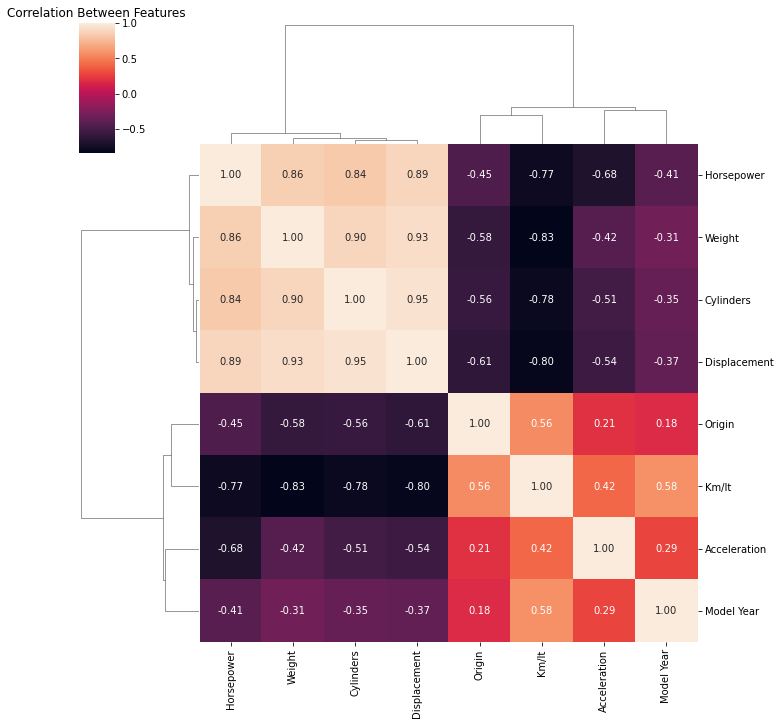

In [8]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation Between Features");

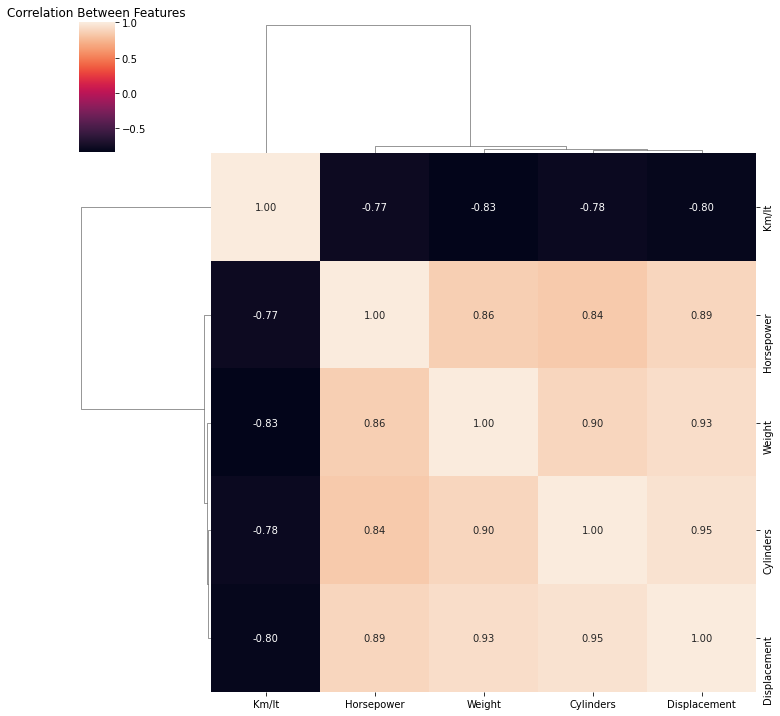

In [9]:
threshold = 0.75
filter1 = np.abs(corr_matrix["Km/lt"]) > threshold
corr_features = corr_matrix.columns[filter1].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features")
plt.show()

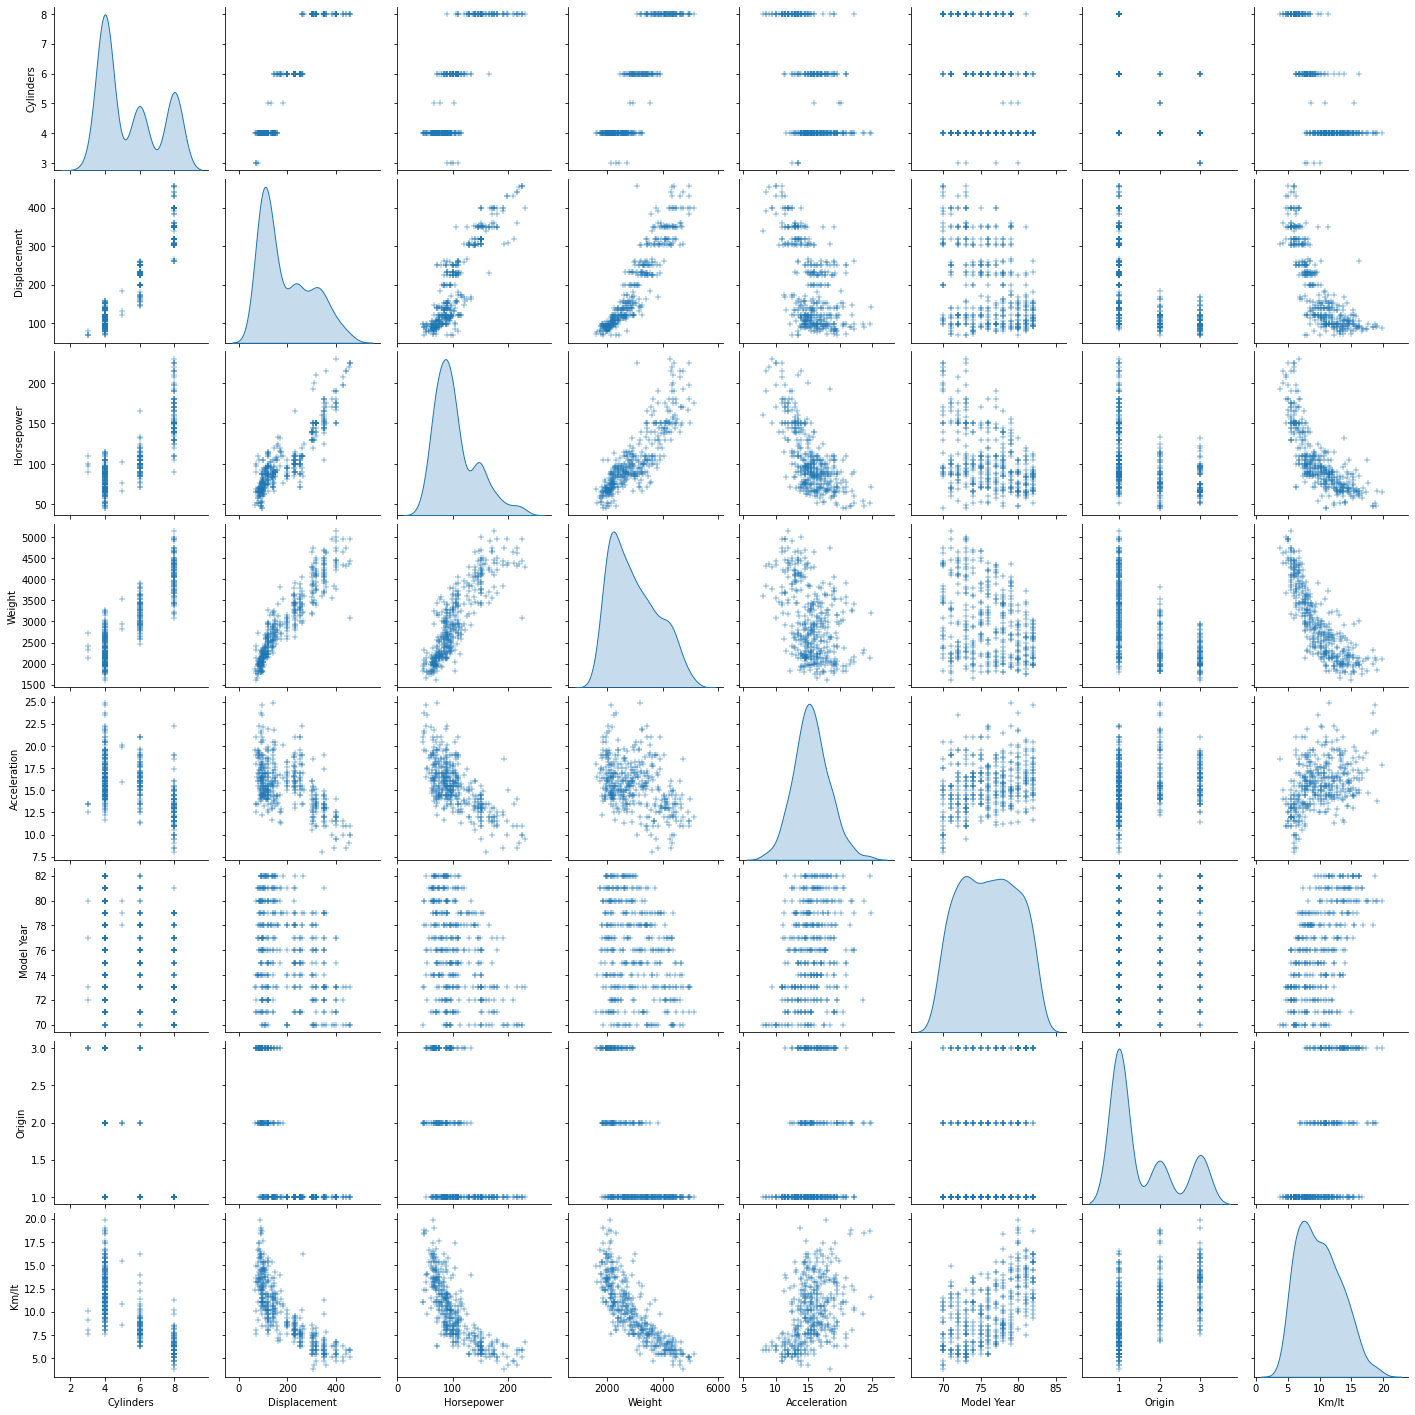

In [10]:
sns.pairplot(df, diag_kind = "kde", markers = "+")

- Multicollinearity
- Cylinders and Origin can be categorical
- Outlier: Horsepower and Acceleration

## Removing Outliers

In [11]:
threshold1 = 2

In [12]:
# remove Horsepower outliers
horsepower_desc = df["Horsepower"].describe()
hp_q3 = horsepower_desc[6]
hp_q1 = horsepower_desc[4]
hp_IQR = hp_q3 - hp_q1
top_limit_hp = hp_q3 + threshold1*hp_IQR
bottom_limit_hp = hp_q1 - threshold1*hp_IQR
filter_hp_bottom = bottom_limit_hp < df["Horsepower"]
filter_hp_top = top_limit_hp > df["Horsepower"]
filter_hp = filter_hp_bottom & filter_hp_top

df = df[filter_hp]

In [13]:
# remove Acceleration outliers
acc_desc = df["Acceleration"].describe()
acc_q3 = acc_desc[6]
acc_q1 = acc_desc[4]
acc_IQR = acc_q3 - acc_q1
top_limit_acc = acc_q3 + threshold1*acc_IQR
bottom_limit_acc = acc_q1 - threshold1*acc_IQR
filter_acc_bottom = bottom_limit_acc < df["Acceleration"]
filter_acc_top = top_limit_acc > df["Acceleration"]
filter_acc = filter_acc_bottom & filter_acc_top

df = df[filter_acc]

## Feature Engineering

### Skewness

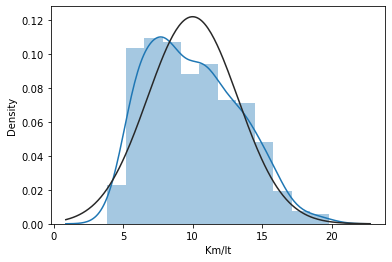

In [14]:
sns.distplot(df["Km/lt"], fit = norm);

In [15]:
(mu, sigma) = norm.fit(df["Km/lt"])

In [16]:
mu

9.990557802557547

In [17]:
sigma

3.2645106240531945

In [18]:
df["Km/lt"] = np.log1p(df["Km/lt"])

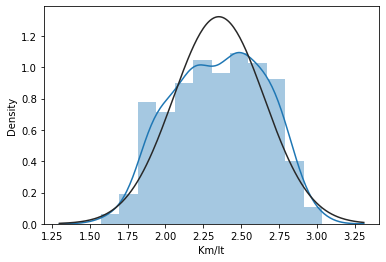

In [19]:
sns.distplot(df["Km/lt"], fit = norm);

In [20]:
(mu, sigma) = norm.fit(df["Km/lt"])

In [21]:
mu

2.3523476065792392

In [22]:
sigma

0.3014181206445401

In [23]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])

### One Hot Encoding

In [24]:
df["Cylinders"] = df["Cylinders"].astype(str)
df["Origin"] = df["Origin"].astype(str)

In [25]:
df = pd.get_dummies(df)

### Splitting

In [26]:
x = df.drop(["Km/lt"], axis = 1)
y = df["Km/lt"]

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.9, random_state = 58)

### Standardization

In [28]:
scaler = StandardScaler()

In [29]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Regression Models

### Linear Regression

In [31]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("LR Coef: ", lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Linear Regression MSE: ", mse)

LR Coef:  [ 1.00385163e-01 -4.85711648e-02 -2.87197887e-01  7.28303195e-04
  1.11239527e-01 -3.52773599e-02  3.23226786e-05 -4.16333634e-17
 -3.54831228e-03  1.83838238e-02 -3.01029327e-02  1.18321587e-02
  2.41336438e-02]
Linear Regression MSE:  0.013152095404199675


### Ridge Regression

In [32]:
ridge = Ridge(random_state = 58, max_iter = 10000)

In [33]:
alphas = np.logspace(-4, -0.5, 30)

In [34]:
tuned_params = [{"alpha": alphas}]

In [36]:
clf = GridSearchCV(ridge, tuned_params, cv = 5, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [37]:
print("Ridge Coef: ", clf.best_estimator_.coef_)

Ridge Coef:  [ 0.09022815 -0.05077846 -0.27879925 -0.00094515  0.1103462  -0.03665806
 -0.00089731  0.         -0.00332587  0.01990951 -0.02955037  0.01077395
  0.02438558]


In [39]:
ridge = clf.best_estimator_
ridge

Ridge(alpha=0.04520353656360245, max_iter=10000, random_state=58)

In [44]:
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Ridge MSE: ", mse)

Ridge MSE:  0.01297839495707987


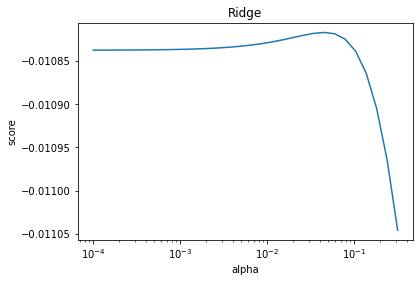

In [43]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge");

### Lasso Regression

In [45]:
lasso = Lasso(random_state = 58, max_iter = 10000)

In [46]:
alphas = np.logspace(-4, -0.5, 30)

In [47]:
tuned_params = [{"alpha": alphas}]

In [48]:
clf = GridSearchCV(lasso, tuned_params, cv = 5, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [49]:
print("Lasso Coef: ", clf.best_estimator_.coef_)

Lasso Coef:  [ 0.         -0.0385309  -0.21680972 -0.          0.09368651 -0.03774984
  0.          0.         -0.          0.01999974 -0.01362267  0.
  0.02704891]


In [50]:
lasso = clf.best_estimator_
lasso

Lasso(alpha=0.004893900918477494, max_iter=10000, random_state=58)

In [51]:
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Lasso MSE: ", mse)

Lasso MSE:  0.011853468199502504


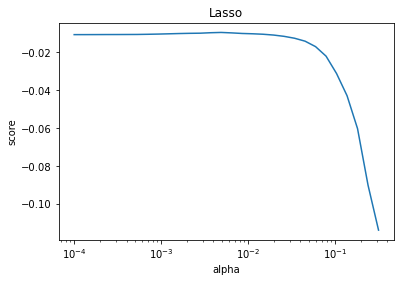

In [54]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso");

### ElasticNet

In [56]:
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv= 5, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, Y_train)


print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("ElasticNet Best Estimator: ",clf.best_estimator_)


y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [ 0.         -0.03893772 -0.21714523 -0.          0.09409074 -0.03803835
  0.          0.         -0.          0.02101295 -0.01387025  0.
  0.02699539]
ElasticNet Best Estimator:  ElasticNet(alpha=0.004893900918477494, l1_ratio=0.9500000000000001,
           max_iter=10000, random_state=42)
ElasticNet MSE:  0.011854666763887025


### XGBoost

In [60]:
parametersGrid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = 5, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    5.9s finished


[11:20:19] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor MSE:  0.01604149455683416


## Averaging Models

In [61]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)  


averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)

[11:21:10] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Averaged Models MSE:  0.011503720926678812


- Linear Regression MSE:  0.013152095404199675
- Ridge MSE:  0.01297839495707987
- Lasso MSE:  0.011853468199502504
- ElasticNet MSE:  0.011854666763887025
- XGBRegressor MSE: 0.01604149455683416
- Averaged Models MSE: 0.011503720926678812